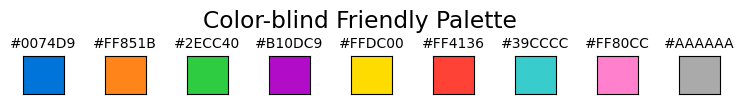

In [1]:
import re
import sys
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.weight'] = 'normal' 
plt.rcParams['font.size'] = 14

from tqdm import tqdm
from dataclasses import dataclass
from pathlib import Path
from scipy.interpolate import interp1d
from collections import defaultdict
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.axisartist.axislines import AxesZero

HOME = Path.cwd().parent
sys.path.append(str(HOME))

from src.data import BatteryData
from src.builders import MODELS
from src.utils import import_config

pd.options.display.precision = 1
palette = [
    '#0074D9',  # blue
    '#FF851B',  # orange
    '#2ECC40',  # green
    '#B10DC9',  # purple
    '#FFDC00',  # yellow
    '#FF4136',  # red
    '#39CCCC',  # teal
    '#FF80CC',  # pink
    '#AAAAAA',  # gray
]
# Show palette
fig, axes = plt.subplots(1, len(palette), figsize=(len(palette), 0.5))
for color, ax in zip(palette, axes):
    ax.set_facecolor(color)
    ax.set_title(color, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
fig.suptitle('Color-blind Friendly Palette', y=1.8)
plt.subplots_adjust(wspace=1, hspace=1)
plt.show()

In [2]:
import re
import numpy as np
import pandas as pd

from pathlib import Path
from collections import defaultdict

HOME = Path.cwd().parent
workspace = HOME / 'workspaces'

In [3]:
# Helper functions
def format_scores(scores, show_max_min: bool = True):
    mean = np.mean(scores)
    std = np.std(scores)
    if show_max_min:
        min_ = np.min(scores)
        max_ = np.max(scores)
        return f'{mean:.0f}±{std:.0f}'
    else:
        return f'{mean:.0f}±{std:.0f}'

def format_df(res_dict, agg_fn):
    new_res = {
        k: {
            key: agg_fn(val) for key, val in v.items()
        } for k, v in res_dict.items()
    }
    return pd.DataFrame(new_res)

def extract_scores(log_filename):
    with open(log_filename, 'r') as f:
        last_line = f.read().splitlines()[-1]
    scores = {}
    try:
        rmse, mae, mape = re.findall(r'[^:]+: (\d+\.\d+)', last_line)
    except:
        print(log_filename, last_line)
        raise
    scores['RMSE'] = float(rmse) 
    scores['MAE'] = float(mae)
    scores['MAPE'] = float(mape) * 100
    return scores

In [9]:
datasets_to_use = ['matr_1', 'matr_2', 'hust', 'mix_20', 'mix_100']
sklearn_baseline_names = [
    'dummy',
    'variance_model',
    'discharge_model',
    'full_model',
    'ridge',
    'pcr',
    'plsr',
    'svm',
    'rf'
]
nn_baseline_names = ['mlp', 'cnn', 'lstm']

def collect_results(dataset):
    sklearn_results = [
        sklearn_baselines[dataset][name] for name in sklearn_baseline_names
    ]
    nn_results = [
        nn_baselines[dataset][name] for name in nn_baseline_names
    ]
    our_results = [ours[dataset]['Ours']]
    return sklearn_results + nn_results + our_results

sklearn_baselines = defaultdict(dict)
for method_path in workspace.glob('baselines/sklearn/*'):
    method = method_path.name
    for dataset_res in method_path.glob('*'):
        dataset = dataset_res.name
        score = extract_scores(dataset_res / 'log.0')['RMSE']
        sklearn_baselines[dataset][method] = score

nn_baselines = defaultdict(dict)
for method_path in workspace.glob('baselines/nn_models/*'):
    method = method_path.name
    for dataset_res in method_path.glob('*'):
        dataset = dataset_res.name
        scores = []
        for i in range(8):
            score = extract_scores(dataset_res / f'log.{i}')['RMSE']
            scores.append(score)
        nn_baselines[dataset][method] = scores
ours = defaultdict(dict)

method = 'Ours'
for dataset_res in workspace.glob('ablation/diff_branch/batlinet/*'):
    dataset = dataset_res.name
    try:
        scores = []
        for i in range(8):
            score = extract_scores(dataset_res / f'log.{i}')['RMSE']
            scores.append(score)
        ours[dataset][method] = scores
    except:
        ours[dataset][method] = 'none'

sklearn_baselines['variance_model']['matr_1'] = 138
sklearn_baselines['variance_model']['matr_2'] = 196
sklearn_baselines['discharge_model']['matr_1'] = 86
sklearn_baselines['discharge_model']['matr_2'] = 173
sklearn_baselines['full_model']['matr_1'] = 100
sklearn_baselines['full_model']['matr_2'] = 214
sklearn_baselines['ridge']['matr_1'] = 125
sklearn_baselines['ridge']['matr_2'] = 188
sklearn_baselines['pcr']['matr_1'] = 100
sklearn_baselines['pcr']['matr_2'] = 176
sklearn_baselines['plsr']['matr_1'] = 97
sklearn_baselines['plsr']['matr_2'] = 193
sklearn_baselines['rf']['matr_1'] = 140
sklearn_baselines['rf']['matr_2'] = 202

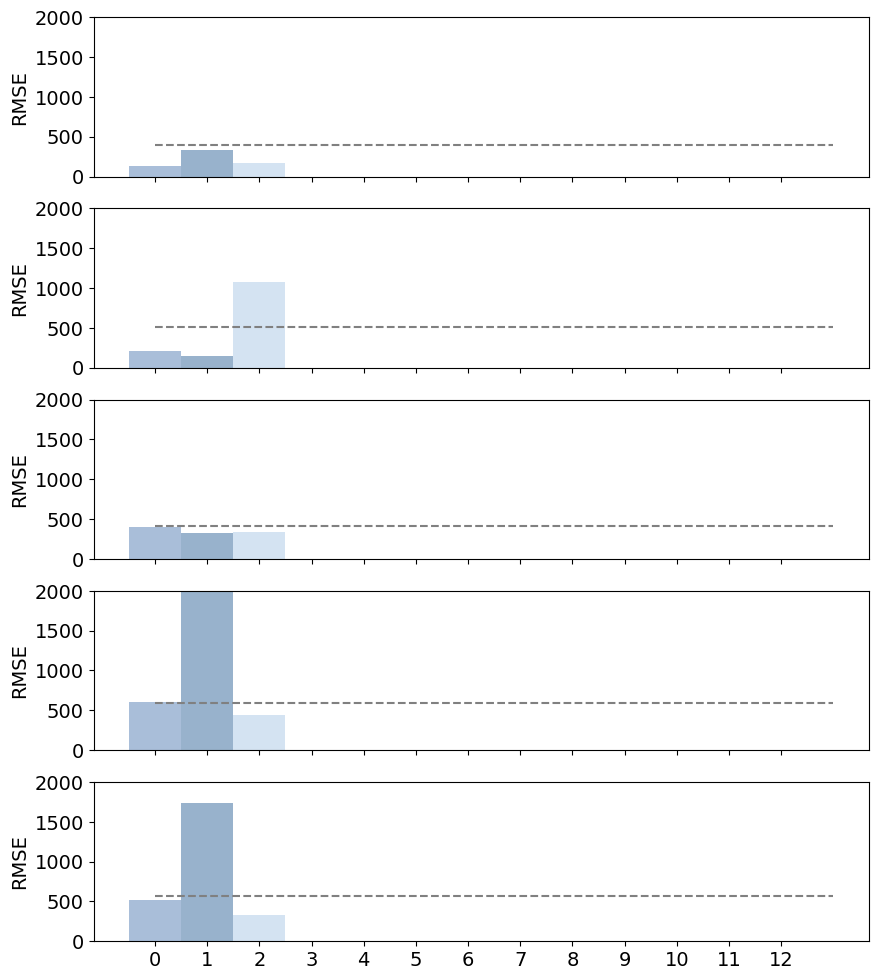

In [16]:
fig, axes = plt.subplots(5, 1, figsize=(10, 12), sharex='col')
colors = [
    '#A9BED9', '#98B2CC', '#D4E3F2',  # Darker blues
    '#E3F0F6', '#D6EAF0', '#D0E6ED', '#E8F5FA',  # Lighter blues
    '#E8A19D', '#E89D9D',  # Yellow
    '#FEE3C3'  # Red
]

for ax, dataset in zip(axes, datasets_to_use):
    # A dashed line for dummy model
    ax.hlines(
        y=[sklearn_baselines[dataset]['dummy']],
        xmin=0,
        xmax=13,
        colors='gray',
        linestyle='dashed'
    )

    x = 0
    severson_baselines = ['variance_model', 'discharge_model', 'full_model']
    for method in severson_baselines:
        ax.bar(
            x=x,
            height=sklearn_baselines[dataset][method],
            width=1,
            color=colors[x]
        )
        x += 1
    x -= 0.5

for ax in axes:
    ax.set_ylabel('RMSE')
    ax.set_xticks(np.arange(
        len(sklearn_baseline_names) + len(nn_baseline_names) + 1
    ))
    ax.set_ylim([0, 2000])
plt.show()

In [14]:
ours

defaultdict(dict,
            {'matr_1': {'Ours': [63.93,
               59.92,
               63.98,
               56.95,
               64.87,
               62.8,
               69.09,
               62.74]},
             'matr_2': {'Ours': [162.34,
               159.71,
               154.45,
               180.14,
               152.82,
               147.77,
               162.17,
               172.81]},
             'mix_20': {'Ours': [222.49,
               240.15,
               203.77,
               202.88,
               192.49,
               183.42,
               196.45,
               214.55]},
             'hust': {'Ours': [257.49,
               283.84,
               285.66,
               229.32,
               246.73,
               282.69,
               239.66,
               320.27]},
             'mix_100': {'Ours': [152.83,
               163.94,
               166.05,
               202.3,
               168.98,
               151.5,
               164.72,